# 1. EFFECTIVENESS OF THE ONLINE LEARNING RULE

## Setup the environment

#### Adding the source code path

In [1]:
import sys  
sys.path.insert(1, './../../ESN-IP/IP/.')

In [2]:
import random

random.seed(10)

#### Import experiment data 

In [3]:
from DATA import NARMA10

data = NARMA10(True, [80,0,20])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()

## NOT PRETRAINED RESERVOIR

In [4]:
N_UNITS = 150

In [5]:
from IPReservoir import IPReservoir
from ESN import Reservoir, EchoStateNetwork
from IntrinsicPlasticity import IPMask

simple_reservoir = Reservoir(N = N_UNITS, sparsity=0.9, ro_rescale=0.25, bias = True)

W_x = simple_reservoir.W_x
W_u = simple_reservoir.W_u
b_x = simple_reservoir.b_x
b_u = simple_reservoir.b_u

In [6]:
Y_TS.shape

torch.Size([2000])

In [7]:
esn = EchoStateNetwork(simple_reservoir) 

In [8]:
esn.train(X_TR, Y_TR, 0, 100, True)

Reservoir warmed up with the first 100 time steps


array([0.296875, 0.234375, 0.25    , ..., 0.265625, 0.1875  , 0.25    ],
      dtype=float32)

1.9868313048491584

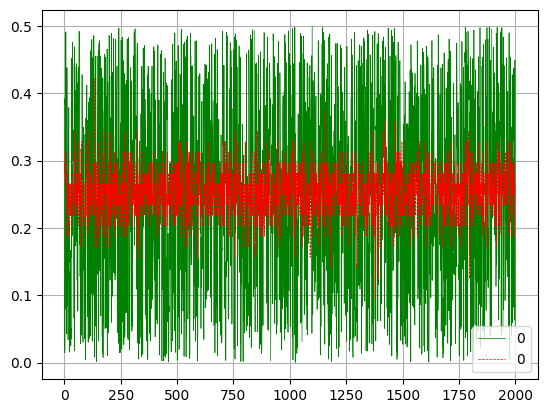

In [9]:
esn.evaluate(X_TS,Y_TS,plot=True)

## PRETRANING WITH OLD STYLE INTRINSIC PLASTICITY

In [10]:
ip_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.normalMask(N_UNITS), bias = True)

ip_reservoir.W_x = W_x
ip_reservoir.W_u = W_u
ip_reservoir.b_x = b_x
ip_reservoir.b_u = b_u

In [11]:
ip_reservoir.pre_train(X_TR, eta=0.000005, epochs=10,  learning_rule="online", verbose=True) #16

- Epoch: 1) | KL Divergence value: 2857.4521484375.
- Epoch: 2) | KL Divergence value: 2839.923828125.
- Epoch: 3) | KL Divergence value: 2822.373291015625.
- Epoch: 4) | KL Divergence value: 2804.810302734375.
- Epoch: 5) | KL Divergence value: 2787.246826171875.
- Epoch: 6) | KL Divergence value: 2769.694580078125.
- Epoch: 7) | KL Divergence value: 2752.163818359375.
- Epoch: 8) | KL Divergence value: 2734.65380859375.
- Epoch: 9) | KL Divergence value: 2717.185302734375.
- Epoch: 10) | KL Divergence value: 2699.758544921875.


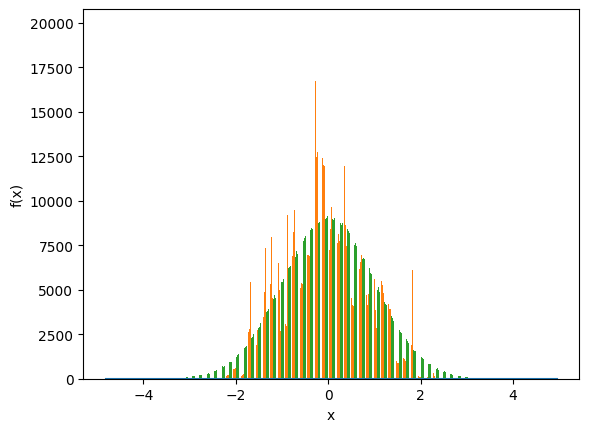

In [12]:
ip_reservoir.predict(X_TR, save_gradients=False, save_states=True)
ip_reservoir.plot_global_neural_activity()

In [13]:
ip_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (0.5590212345123291)  ACTUAL_STD == (0.10318626463413239)][ TARGET_MEAN == (-0.004585354123264551) TARGET_STD == (0.9953218102455139)]
Unit - (2): [ ACTUAL_MEAN == (-1.0456039905548096)  ACTUAL_STD == (0.05260772630572319)][ TARGET_MEAN == (0.005737887695431709) TARGET_STD == (1.0050913095474243)]
Overall network: [ACTUAL_MEAN == (-0.07852312177419662)  ACTUAL_STD == (0.8629549741744995)]


## BIMODAL MIXTURE OF GAUSSIAN

In [14]:
# It seems that switching the "old" bias terms down (input bias and recurrent weights bias), 
# helps the algorithm converging earlier, letting the IP bias dominate the linear translation. 

bimodal_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.mixedBimodalMask(N_UNITS), bias = False)

bimodal_reservoir.W_x = W_x
bimodal_reservoir.W_u = W_u
#bimodal_reservoir.b_x = b_x
#bimodal_reservoir.b_u = b_u

In [15]:
bimodal_reservoir.pre_train(X_TR, eta= 0.0000015, epochs=15,  learning_rule="online", verbose=True)

- Epoch: 1) | KL Divergence value: 3482.2646484375.
- Epoch: 2) | KL Divergence value: 3323.600341796875.
- Epoch: 3) | KL Divergence value: 3173.095947265625.
- Epoch: 4) | KL Divergence value: 3031.255859375.
- Epoch: 5) | KL Divergence value: 2898.431396484375.
- Epoch: 6) | KL Divergence value: 2774.833740234375.
- Epoch: 7) | KL Divergence value: 2660.53759765625.
- Epoch: 8) | KL Divergence value: 2555.498779296875.
- Epoch: 9) | KL Divergence value: 2459.5712890625.
- Epoch: 10) | KL Divergence value: 2372.525634765625.
- Epoch: 11) | KL Divergence value: 2294.062255859375.
- Epoch: 12) | KL Divergence value: 2223.830078125.
- Epoch: 13) | KL Divergence value: 2161.444091796875.
- Epoch: 14) | KL Divergence value: 2106.49658203125.
- Epoch: 15) | KL Divergence value: 2058.58447265625.


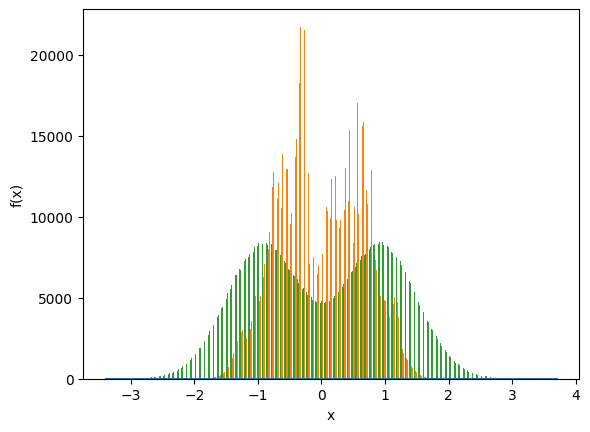

In [16]:
bimodal_reservoir.predict(X_TR, save_gradients=False, save_states=True)
bimodal_reservoir.plot_global_neural_activity()

In [17]:
bimodal_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (-0.00022558821365237236)  ACTUAL_STD == (0.0906348004937172)][ TARGET_MEAN == (-0.9206508994102478) TARGET_STD == (0.5794012546539307)]
Unit - (2): [ ACTUAL_MEAN == (0.6476046442985535)  ACTUAL_STD == (0.05813320726156235)][ TARGET_MEAN == (0.9173092246055603) TARGET_STD == (0.575241208076477)]
Overall network: [ACTUAL_MEAN == (-0.01048970501869917)  ACTUAL_STD == (0.6467006206512451)]


## EVAUALTUION IN ESN

In [18]:
from ESN import EchoStateNetwork

simple_esn = EchoStateNetwork(simple_reservoir)
ip_esn = EchoStateNetwork(ip_reservoir)
bimodal_esn = EchoStateNetwork(bimodal_reservoir)

simple_esn.reservoir.reset_initial_state()
ip_esn.reservoir.reset_initial_state()
bimodal_esn.reservoir.reset_initial_state()

simple_esn.reservoir.warm_up(X_TR[0:100])
ip_esn.reservoir.warm_up(X_TR[0:100])
bimodal_esn.reservoir.warm_up(X_TR[0:100])

simple_esn.train(X_TR[100:None], Y_TR[100:None], 0)
ip_esn.train(X_TR[100:None], Y_TR[100:None], 0)
bimodal_esn.train(X_TR[100:None], Y_TR[100:None], 0)


Reservoir warmed up with the first 100 time steps
Reservoir warmed up with the first 100 time steps
Reservoir warmed up with the first 100 time steps


array([0.27734375, 0.203125  , 0.23046875, ..., 0.2763672 , 0.234375  ,
       0.234375  ], dtype=float32)

### COMPARISON ON TEST DATA

In [19]:
from Metrics import NRMSE, MSE

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.022405825295571988


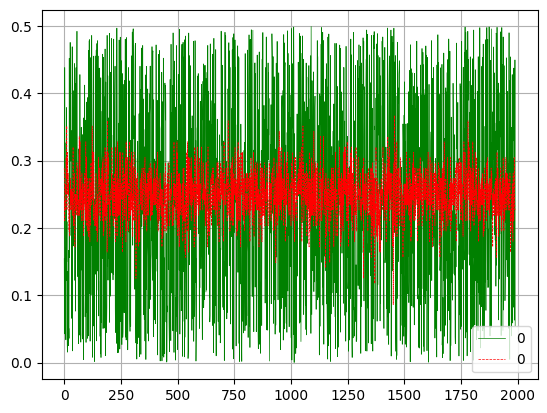

In [20]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.02197786982996269


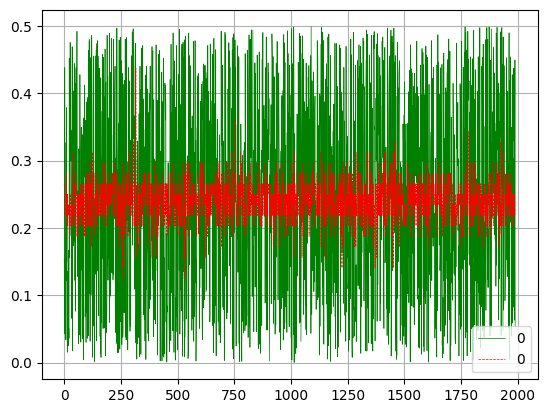

In [21]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { ip_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.02184599045617604


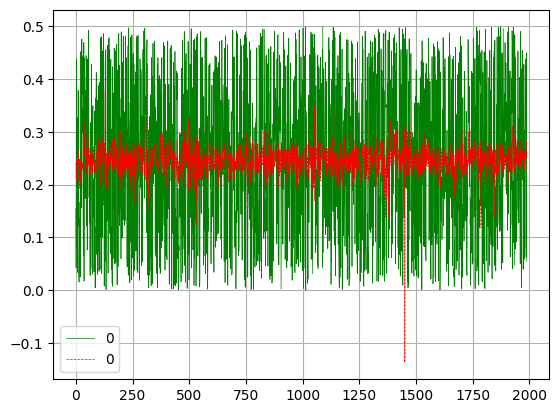

In [22]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { bimodal_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

## LYAPUNOV EXPONENTS

In [23]:
simple_esn.reservoir.LCE(X_TS)

-1.7098527

In [24]:
ip_esn.reservoir.LCE(X_TS)

-1.4411151

In [25]:
bimodal_esn.reservoir.LCE(X_TS)

-1.1189696

## MEMORY CAPACITY

In [26]:
def mean_mc(esn: EchoStateNetwork, rep):
    mc = 0
    for _ in range(rep):
        mc += esn.MemoryCapacity()

    return mc/rep

In [27]:
mean_mc(simple_esn, 5)

tensor(7.0075)

In [28]:
mean_mc(ip_esn, 5)

tensor(10.9251)

In [29]:
mean_mc(bimodal_esn, 5)

tensor(10.9724)

## DEVIATION FROM LINEARITY

In [30]:
simple_esn.reservoir.de_fi()

0.1296502681188008

In [31]:
ip_esn.reservoir.de_fi()

0.06946652730595815

In [32]:
bimodal_esn.reservoir.de_fi()

0.14155401980811744